In [28]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import skimage as ski
import skimage.io
import skimage.transform
from scipy.fft import dct,idct,dctn,idctn
import cv2

Load in the image and down sample it so that CVXPY can solve the problem in a reasonable amount of time.

Original size:  (374, 266)
Rescaled size:  (37, 27)


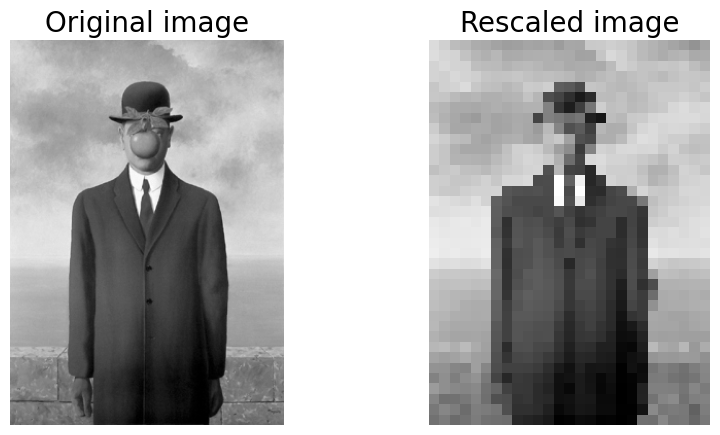

In [29]:
DOWNSAMPLE_RATE = 0.1
img_path = 'SonOfMan.jpg'
# read image
img_full = ski.io.imread(img_path)
# convert to grayscale and visualize 
img_full = ski.color.rgb2gray(img_full)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(img_full, cmap='gray')
ax[0].set_title("Original image", fontsize= 20)
ax[0].axis('off')
print("Original size: ", img_full.shape)
# resize image 
img = ski.transform.rescale(img_full, DOWNSAMPLE_RATE, anti_aliasing=False)
print("Rescaled size: ", img.shape)
ax[1].imshow(img, cmap='gray')
ax[1].set_title("Rescaled image", fontsize= 20)
ax[1].axis('off')
plt.show()

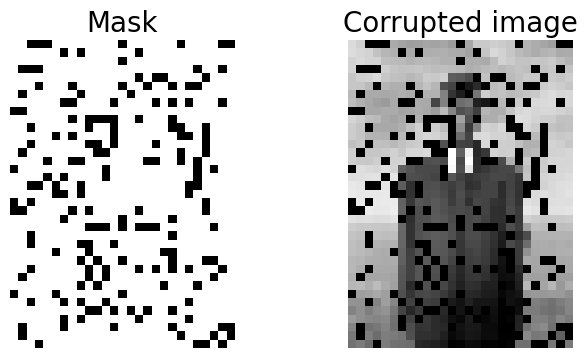

In [30]:
Ny, Nx = img.shape
mask_prop = 0.2
np.random.seed(515)
obs_indices = np.random.choice(Nx*Ny,int(mask_prop*Nx*Ny))
mask = np.ones(Ny*Nx)
mask[obs_indices]=0.
mask = mask.reshape(Ny,Nx)
masked_img = mask * img

fig, ax = plt.subplots(1,2 , figsize=(8, 4))
ax[0].imshow(mask, cmap = 'gray')
ax[0].set_title('Mask', fontsize= 20)
ax[0].axis('off')
ax[1].imshow(mask*img, cmap = 'gray')
ax[1].set_title('Corrupted image', fontsize= 20)
ax[1].axis('off')
plt.show()

In [31]:
def construct_DCT_Mat( Ny, Nx ):
  Dx = dct(np.eye(Nx), axis =0, norm='ortho')
  Dy = dct(np.eye(Ny), axis = 0, norm='ortho')
  A = np.kron(Dy, Dx)
  return A
# construct inverse DCT matrix
def construct_iDCT_Mat( Ny, Nx ):
  Dx = idct(np.eye(Nx), axis =0, norm='ortho')
  Dy = idct(np.eye(Ny), axis = 0, norm = 'ortho')
  invA = np.kron(Dy, Dx)
  return invA

Dmask = np.diag(mask.flatten())
print(Dmask)
print(Dmask.shape)
Ny, Nx = img.shape
dctMat = construct_DCT_Mat(Ny, Nx)
inv_dctMat = construct_iDCT_Mat(Ny, Nx)
print(Ny)
print(Nx)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(999, 999)
37
27


## Compute the solution using CVXPY

Perform Task 2 in the Homework by writing down the "flattened" version of the optimization problem (2) and solve it using CVXPY. 

In [32]:
regularization_parameter = 0.01
xxxtentacion = cvx.Variable(Ny*Nx)
my_objective_function = cvx.Minimize(0.5* cvx.sum_squares(cvx.multiply(mask.flatten(), inv_dctMat@xxxtentacion - img.flatten())) + regularization_parameter * cvx.norm(xxxtentacion, 1))

In [33]:
problem_DrewMcIntyre = cvx.Problem(my_objective_function)
problem_DrewMcIntyre.solve()
sol = xxxtentacion.value

In [34]:
print(sol)
print(sol.shape)
print(problem_DrewMcIntyre)

[ 1.61910562e+01  4.40786861e-01  4.76760761e+00 -4.63272296e-01
  1.75459781e-01  2.72422262e-01 -6.53104362e-01  2.14222235e-02
 -6.85406085e-01  1.28292187e-01  5.89594403e-01 -5.81346574e-02
  4.41937044e-01 -4.80421489e-05 -1.71962688e-01 -1.06634849e-02
 -3.15278255e-01  1.20607847e-03  4.44949433e-02  6.83077303e-02
  1.60143603e-01 -2.06986460e-01  1.74583720e-01 -3.07438813e-03
 -3.28145912e-01  9.75799048e-02 -6.30771134e-05  4.47282000e+00
 -5.77926475e-01 -1.45642166e+00  5.21100012e-01 -7.60731859e-01
  1.00602117e-01  1.11278606e+00 -3.31293060e-01  1.32589777e-01
  2.24336334e-01 -4.51486837e-01 -3.25114345e-02 -1.41858853e-01
  1.09903480e-01 -2.01508698e-05 -6.67121616e-02  2.41067792e-01
 -5.22351488e-05 -3.84837615e-02  1.40337227e-02 -8.44224490e-02
  6.63820276e-04 -9.94035271e-06  1.86939270e-02  5.35873677e-02
 -1.08199128e-01  9.59272810e-02 -6.46722078e-01 -6.62658173e-02
 -1.17787189e+00  8.03059811e-02 -6.30474752e-01  1.05202944e-01
  6.67566664e-01  1.39624

## Evaluate the reconstruction here
We calculate mean squared error on the masked out pixels relative to the variance on the original image. Report these values in your report. 

Mean squared error: 0.04792328392931286


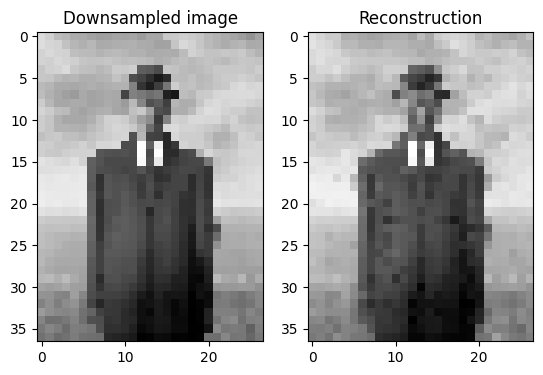

In [35]:
reconstruction = idctn(sol.reshape(Ny,Nx),norm = 'ortho')
relative_mse = np.mean(((1-mask)*(reconstruction - img))**2)/np.var(((1-mask)*img)**2)
print("Mean squared error:",relative_mse)

plt.subplot(1,2,1)
plt.imshow(img,cmap = 'gray')
plt.title("Downsampled image")
plt.subplot(1,2,2)
plt.imshow(reconstruction,cmap ='gray')
plt.title("Reconstruction")
plt.show()

Side note, unrelated to your HW: 

using CVXPY this way is really not a great idea since:
1. We're materializing DCT matrices, which makes calculations expensive. 
2. We're instantiating (large+dense) Kronecker product matrices, these are precisely the A and invA matrices. 

Often, however, for smaller problems (and much harder problems), CVXPY can work incredibly well!
We downsampled the problem a lot so that it'll run quickly, but if you try increasing the resolution by a bit, it'll start taking much much longer. For example, try increasing the DOWNSAMPLE_RATE to 0.2 and you'll see cvxpy slows down a lot. 

Again, You don't need to report this in your report. 

## Implement your own Proximal Gradient Descent

In order to write a fast implementation, you should avoid instantiating matrices whenever possible and just apply the DCT and iDCT functions from Scipy, i.e., scipy.fft.dctn and scipy.fft.idctn may be useful!

In [36]:
def build_objective_components(mask,masked_image,lam):
    cal_kestis = masked_image.flatten()
    
    def f(x):
        return 0.5 * np.sum(mask * (idctn(x.reshape(Ny, Nx), norm='ortho') - cal_kestis.reshape(Ny, Nx))**2)
        
    def gradf(x):
        residual = mask * (idctn(x.reshape(Ny, Nx), norm='ortho') - cal_kestis.reshape(Ny, Nx))
        grad = dctn(residual, norm='ortho')
        return grad

    def L1(x):
        return lam * np.sum(np.abs(x))

    def proxL1(x,t):
        return np.sign(x) * np.maximum(np.abs(x) - t * lam, 0)
    
    return f,gradf,L1,proxL1

def PGD_solve(x0,f,gradf,h,proxh,max_iter =5000,tol = 1e-4):
    x_PGD_solve = x0.copy()
    fx_old = f(x_PGD_solve) + h(x_PGD_solve)
    lipschitz_constant = 1.0
    t = 1/lipschitz_constant
    
    for i in range(max_iter):
        grad = gradf(x_PGD_solve)
        x_next = proxh(x_PGD_solve - t * grad, t)
        fx_new = f(x_next) + h(x_next)
        if np.abs(fx_new - fx_old) < tol:
            print(f"Converged at iteration {i} with objective {fx_new:.6f}.")
            break
        x_PGD_solve = x_next
        fx_old = fx_new
    return x_PGD_solve

First apply your code to the down sampled image and compare to the CVXPY solution to make sure it is working. Report the relative MSE as before.

Converged at iteration 85 with objective 0.955262.
Mean squared error: 0.0502605849843389


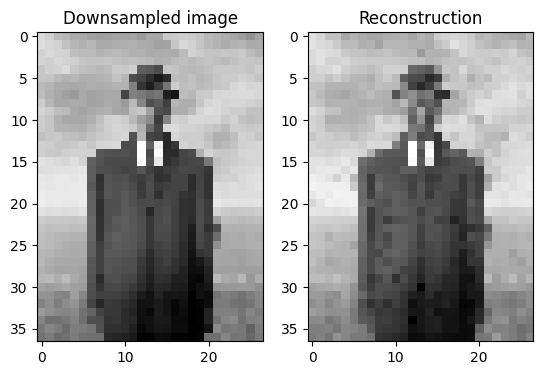

In [37]:
x0newjeans = dctn(masked_img, norm="ortho")

f, gradf, l1, proxl1 = build_objective_components(mask, img, regularization_parameter)

sol_Office_Hours = PGD_solve(x0newjeans, f, gradf, l1, proxl1)

sol_pgd = sol_Office_Hours.reshape(Ny, Nx)
reconstruction = idctn(sol_pgd, norm="ortho")

relative_mse = np.mean(((1-mask)*(reconstruction - img))**2)/np.var(((1-mask)*img)**2)
print("Mean squared error:",relative_mse)

plt.subplot(1,2,1)
plt.imshow(img,cmap = 'gray')
plt.title("Downsampled image")
plt.subplot(1,2,2)
plt.imshow(reconstruction,cmap ='gray')
plt.title("Reconstruction")
plt.show()

Converged at iteration 85 with objective 0.955262.
Mean squared error: 0.0502605849843389


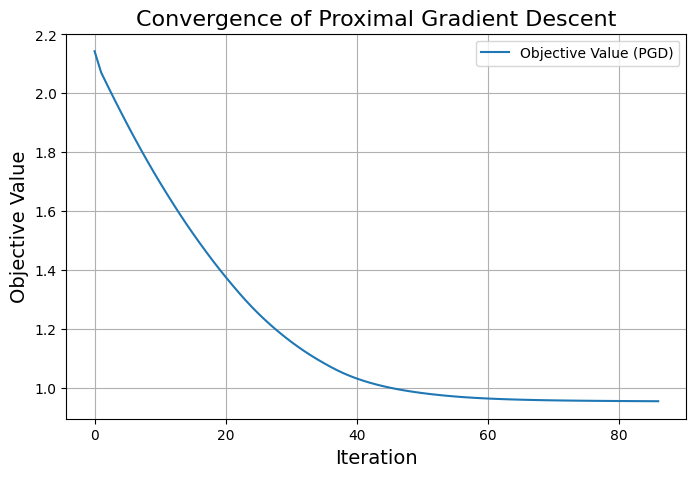

In [38]:
def PGD_solve_with_history(x0,f,gradf,h,proxh,max_iter =5000,tol = 1e-4):
    x_PGD_solve = x0.copy()
    fx_old = f(x_PGD_solve) + h(x_PGD_solve)
    lipschitz_constant = 1.0
    t = 1/lipschitz_constant
    history = [fx_old]
    
    for i in range(max_iter):
        grad = gradf(x_PGD_solve)
        x_next = proxh(x_PGD_solve - t * grad, t)
        fx_new = f(x_next) + h(x_next)
        history.append(fx_new)
        if np.abs(fx_new - fx_old) < tol:
            print(f"Converged at iteration {i} with objective {fx_new:.6f}.")
            break
        x_PGD_solve = x_next
        fx_old = fx_new
    return x_PGD_solve, history

sol_pgd, history = PGD_solve_with_history(x0newjeans, f, gradf, l1, proxl1)

sol_pgd = sol_pgd.reshape(Ny, Nx)
reconstruction = idctn(sol_pgd, norm="ortho")

relative_mse = np.mean(((1-mask)*(reconstruction - img))**2)/np.var(((1-mask)*img)**2)
print("Mean squared error:",relative_mse)

# Convergence plot added here
plt.figure(figsize=(8, 5))
plt.plot(history, label="Objective Value (PGD)")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Objective Value", fontsize=14)
plt.title("Convergence of Proximal Gradient Descent", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

## Now rerun on the full size image with more masking
This should still be pretty fast if you implemented the PGD correctly using the scipy functions. 

Rescaled size:  (374, 266)


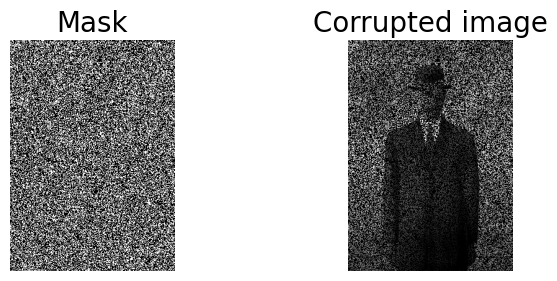

In [39]:
# resize image 
img = ski.transform.rescale(img_full, 1., anti_aliasing=False)
Ny, Nx = img.shape
mask_prop = 0.6
mask_indices = np.random.choice(Nx*Ny,int(mask_prop*Nx*Ny),replace = False)
mask = np.ones(Ny*Nx)
mask[mask_indices]=0.
mask = mask.reshape(Ny,Nx)
masked_img = mask * img
print("Rescaled size: ", img.shape)

ax[1].imshow(img, cmap='gray')
ax[1].set_title("Rescaled image", fontsize= 20)
ax[1].axis('off')
plt.show()

fig, ax = plt.subplots(1,2 , figsize=(8, 3))
ax[0].imshow(mask, cmap = 'gray')
ax[0].set_title('Mask', fontsize= 20)
ax[0].axis('off')
ax[1].imshow(mask*img, cmap = 'gray')
ax[1].set_title('Corrupted image', fontsize= 20)
ax[1].axis('off')
plt.show()

Present a figure comparing the original, corrupted, and recovered images using your algorithm. Also compute the relative MSE of the recovered image and include it in the report. 

Converged at iteration 203 with objective 21.228047.
Mean squared error: 0.005637095073441073


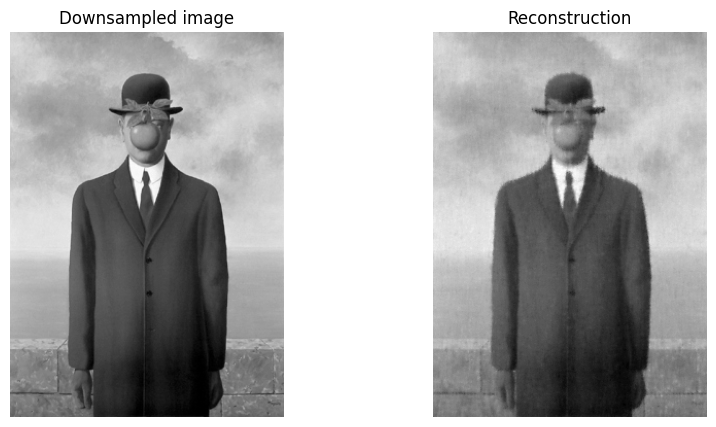

In [40]:
# Initial guess = DCT of the masked image (flattened)
x0 = dctn(masked_img, norm='ortho')

# Build objective components using the fixed gradient
f, gradf, L1, proxL1 = build_objective_components(mask, img, regularization_parameter)

# Solve using Proximal Gradient Descent
sol_pgd = PGD_solve(x0, f, gradf, L1, proxL1)

# Reshape solution back into matrix form
sol_pgd = sol_pgd.reshape(Ny, Nx)

# Apply inverse DCT to reconstruct the image
reconstruction = idctn(sol_pgd, norm='ortho')

# Compute Relative Mean Squared Error (MSE)
relative_mse = np.mean(((1 - mask) * (reconstruction - img))**2) / np.var((1 - mask) * img)
print("Mean squared error:", relative_mse)

# Plot original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Downsampled image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstruction, cmap='gray')
plt.title("Reconstruction")
plt.axis('off')

plt.show()